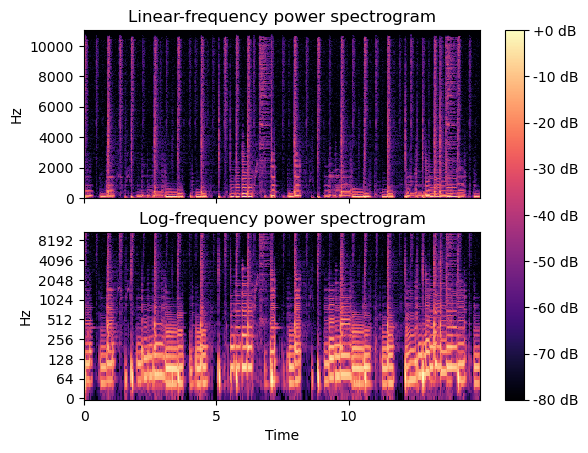

In [6]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
y, sr = librosa.load(librosa.ex('choice'), duration=15)
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram')
ax[0].label_outer()

hop_length = 1024
D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)),
                            ref=np.max)
librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                         x_axis='time', ax=ax[1])
ax[1].set(title='Log-frequency power spectrogram')
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")

Dummy dataframe: 
      X         Y
0  0.00  1.016033
1  0.01  0.388973
2  0.02  0.990908
3  0.03  0.348960
4  0.04  0.954764


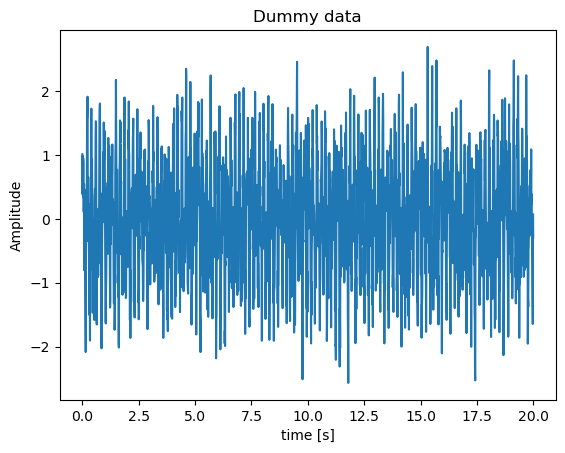

Positions and magnitude of frequency peaks:
5.5000    	 0.4925
10.2000    	 0.2482
18.3000    	 0.1098
-18.3000    	 0.1098
-10.2000    	 0.2482
-5.5000    	 0.4925


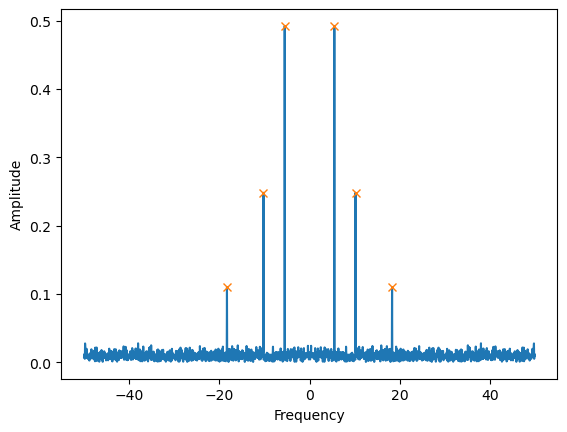

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

# First: Let's generate a dummy dataframe with X,Y
# The signal consists in 3 cosine signals with noise added. We terminate by creating
# a pandas dataframe.

import numpy as np
X=np.arange(start=0,stop=20,step=0.01) # 20 seconds long signal sampled every 0.01[s]

# Signal components given by [frequency, phase shift, Amplitude]
GeneratedSignal=np.array([[5.50, 1.60, 1.0], [10.2, 0.25, 0.5], [18.3, 0.70, 0.2]])

Y=np.zeros(len(X))
# Let's add the components one by one
for P in GeneratedSignal:
    Y+=np.cos(2*np.pi*P[0]*X-P[1])*P[2] 

# Let's add some gaussian random noise (mu=0, sigma=noise):
noise=0.5
Y+=np.random.randn(len(X))*noise

# Let's build the dataframe:
dummy_data=pd.DataFrame({'X':X,'Y':Y})
print('Dummy dataframe: ')
print(dummy_data.head())

# Figure-1: The dummy data

plt.plot(X,Y)
plt.title('Dummy data')
plt.xlabel('time [s]')
plt.ylabel('Amplitude')
plt.show()

# ----------------------------------------------------
# Processing:

headers = ["X","Y"]

#original_data = pd.read_csv("testdata.csv",names=headers)
# Let's take our dummy data:

original_data = dummy_data

x = np.array(original_data["X"])
y = np.array(original_data["Y"])


# Assuming the time step is constant:
# (otherwise you'll need to resample the data at a constant rate).
dt=x[1]-x[0]  # time step of the data

# The fourier transform of y:
yf=fft(y, norm='forward')  
# Note: see  help(fft) --> norm. I chose 'forward' because it gives the amplitudes we put in.
# Otherwise, by default, yf will be scaled by a factor of n: the number of points


# The frequency scale
n = x.size   # The number of points in the data
freq = fftfreq(n, d=dt)

# Let's find the peaks with height_threshold >=0.05
# Note: We use the magnitude (i.e the absolute value) of the Fourier transform

height_threshold=0.05 # We need a threshold. 


# peaks_index contains the indices in x that correspond to peaks:

peaks_index, properties = find_peaks(np.abs(yf), height=height_threshold)

# Notes: 
# 1) peaks_index does not contain the frequency values but indices
# 2) In this case, properties will contain only one property: 'peak_heights'
#    for each element in peaks_index (See help(find_peaks) )

# Let's first output the result to the terminal window:
print('Positions and magnitude of frequency peaks:')
[print("%4.4f    \t %3.4f" %(freq[peaks_index[i]], properties['peak_heights'][i])) for i in range(len(peaks_index))]


# Figure-2: The frequencies

plt.plot(freq, np.abs(yf),'-', freq[peaks_index],properties['peak_heights'],'x')
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks, butter, filtfilt
from scipy.optimize import curve_fit
import numpy as np

# Read the CSV file
df = pd.read_csv('C:/Users/Edward/Dropbox/MPI/Wingbeat/Arizona/flightcage/example_flight_cage_fleatag.csv')
x = df['time'].values
y = df['accZ_mg'].values

# Assuming the time step is constant:
# (otherwise you'll need to resample the data at a constant rate).
dt = 1 / 54  # time step of the data (sampling frequency is 54 Hz)

# Apply bandpass filter between 5 and 20 Hz
lowcut = 5
highcut = 20
order = 5

nyquist = 0.5 * (1 / dt)
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(order, [low, high], btype='band')
filtered_data = filtfilt(b, a, y)

# The Fourier transform of filtered_data:
yf = fft(filtered_data, norm='forward')
# Note: see help(fft) --> norm. I chose 'forward' because it gives the amplitudes we put in.
# Otherwise, by default, yf will be scaled by a factor of n: the number of points

# The frequency scale
n = x.size  # The number of points in the data
freq = fftfreq(n, d=dt)

# Remove negative frequency values
positive_freq_mask = freq >= 0
freq = freq[positive_freq_mask]
yf = yf[positive_freq_mask]

# Let's find the peaks with height_threshold >= 0.05
# Note: We use the magnitude (i.e., the absolute value) of the Fourier transform

height_threshold = 0.05  # We need a threshold.

# peaks_index contains the indices in x that correspond to peaks:
peaks_index, properties = find_peaks(abs(yf), height=height_threshold)

# Notes:
# 1) peaks_index does not contain the frequency values but indices
# 2) In this case, properties will contain only one property: 'peak_heights'
#    for each element in peaks_index (See help(find_peaks) )

# Filter peaks based on amplitude threshold
amplitudes = properties['peak_heights']
valid_peak_indices = peaks_index[amplitudes > 10]
valid_peak_amplitudes = amplitudes[amplitudes > 10]
valid_peak_frequencies = freq[valid_peak_indices]

if len(valid_peak_amplitudes) > 0:
    # Bin frequencies and select maximum amplitude value from each bin
    bin_width = 0.01
    bins = np.arange(np.min(valid_peak_frequencies), np.max(valid_peak_frequencies) + bin_width, bin_width)
    digitized = np.digitize(valid_peak_frequencies, bins)
    binned_amplitudes = [np.max(valid_peak_amplitudes[digitized == i]) for i in range(1, len(bins))]

    # Find corresponding frequencies for the maximum amplitudes
    valid_peak_frequencies = bins[:-1] + bin_width / 2

    # Fit a Gaussian distribution to valid peak frequencies
    def gaussian(x, mu, sigma):
        return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

   


ValueError: zero-size array to reduction operation maximum which has no identity